Running this file will download CIFAR10 and place the images into a
training folder and test folder in the current directory
These will be used for the three demos in this folder. 
Please note this will take a few minutes to run, but only needs to be run
once.

Copyright 2017 The MathWorks, Inc.

In [36]:
%%file saveCIFAR10AsFolderOfImages.m
function saveCIFAR10AsFolderOfImages(inputPath, outputPath, varargin)
% saveCIFAR10AsFolderOfImages   Save the CIFAR-10 dataset as a folder of images
%   saveCIFAR10AsFolderOfImages(inputPath, outputPath) takes the CIFAR-10
%   dataset located at inputPath and saves it as a folder of images to the
%   directory outputPath. If inputPath or outputPath is an empty string, it
%   is assumed that the current folder should be used.
%
%   saveCIFAR10AsFolderOfImages(..., labelDirectories) will save the
%   CIFAR-10 data so that instances with the same label will be saved to
%   sub-directories with the name of that label.

% Check input directories are valid
if(~isempty(inputPath))
    assert(exist(inputPath,'dir') == 7);
end
if(~isempty(outputPath))
    assert(exist(outputPath,'dir') == 7);
end

% Check if we want to save each set with the same labels to its own
% directory.
if(isempty(varargin))
    labelDirectories = false;
else
    assert(nargin == 3);
    labelDirectories = varargin{1};
end

% Set names for directories
trainDirectoryName = 'cifar10Train';
testDirectoryName = 'cifar10Test';

% Create directories for the output
mkdir(fullfile(outputPath, trainDirectoryName));
mkdir(fullfile(outputPath, testDirectoryName));

if(labelDirectories)
    labelNames = {'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'};
    iMakeTheseDirectories(fullfile(outputPath, trainDirectoryName), labelNames);
    iMakeTheseDirectories(fullfile(outputPath, testDirectoryName), labelNames);
    for i = 1:5
        iLoadBatchAndWriteAsImagesToLabelFolders(fullfile(inputPath,['data_batch_' num2str(i) '.mat']), fullfile(outputPath, trainDirectoryName), labelNames, (i-1)*10000);
    end
    iLoadBatchAndWriteAsImagesToLabelFolders(fullfile(inputPath,'test_batch.mat'), fullfile(outputPath, testDirectoryName), labelNames, 0);
else
    for i = 1:5
        iLoadBatchAndWriteAsImages(fullfile(inputPath,['data_batch_' num2str(i) '.mat']), fullfile(outputPath, trainDirectoryName), (i-1)*10000);
    end
    iLoadBatchAndWriteAsImages(fullfile(inputPath,'test_batch.mat'), fullfile(outputPath, testDirectoryName), 0);
end
end

function iLoadBatchAndWriteAsImagesToLabelFolders(fullInputBatchPath, fullOutputDirectoryPath, labelNames, nameIndexOffset)
load(fullInputBatchPath);
data = data'; %#ok<NODEF>
data = reshape(data, 32,32,3,[]);
data = permute(data, [2 1 3 4]);
for i = 1:size(data,4)
    imwrite(data(:,:,:,i), fullfile(fullOutputDirectoryPath, labelNames{labels(i)+1}, ['image' num2str(i + nameIndexOffset) '.png']));
end
end

function iLoadBatchAndWriteAsImages(fullInputBatchPath, fullOutputDirectoryPath, nameIndexOffset)
load(fullInputBatchPath);
data = data'; %#ok<NODEF>
data = reshape(data, 32,32,3,[]);
data = permute(data, [2 1 3 4]);
for i = 1:size(data,4)
    imwrite(data(:,:,:,i), fullfile(fullOutputDirectoryPath, ['image' num2str(i + nameIndexOffset) '.png']));
end
end

function iMakeTheseDirectories(outputPath, directoryNames)
for i = 1:numel(directoryNames)
    mkdir(fullfile(outputPath, directoryNames{i}));
end
end

Created file '/home/dreuter/Github/matlab-paths/DeepLearning/saveCIFAR10AsFolderOfImages.m'.


In [39]:
%%file readFunctionTrain.m
% This function simply resizes the images to fit in AlexNet
% Copyright 2017 The MathWorks, Inc.
function I = readFunctionTrain(filename)
% Resize the images to the size required by the network.
I = imread(filename);
I = imresize(I, [227 227]);

Created file '/home/dreuter/Github/matlab-paths/DeepLearning/readFunctionTrain.m'.


In [38]:
%% Download the CIFAR-10 dataset
if ~exist('cifar-10-batches-mat','dir')
    cifar10Dataset = 'cifar-10-matlab';
    disp('Downloading 174MB CIFAR-10 dataset...');   
    websave([cifar10Dataset,'.tar.gz'],...
        ['https://www.cs.toronto.edu/~kriz/',cifar10Dataset,'.tar.gz']);
    gunzip([cifar10Dataset,'.tar.gz'])
    delete([cifar10Dataset,'.tar.gz'])
    untar([cifar10Dataset,'.tar'])
    delete([cifar10Dataset,'.tar'])
end    

%% Prepare the CIFAR-10 dataset
if ~exist('cifar10Train','dir')
    disp('Saving the Images in folders. This might take some time...');    
    saveCIFAR10AsFolderOfImages('cifar-10-batches-mat', pwd, true);
end

### Deep Learning Example: Traning from scratch using CIFAR-10 Dataset
Copyright 2017 The MathWorks, Inc.
This example explores creating a convolutional neural network (CNN) from scratch. 
You will need to download images in order to run this example.
Please see the file in this directory: DownloadCIFAR10.m 
Running this file will help you download CIFAR10 if you choose to use those images.

In [4]:
% Load training data
% Please note: these are 4 of the 10 categories available
% Feel free to choose which ever you like best!
categories = {'deer','dog','frog','cat'};

rootFolder = 'cifar10Train';
imds = imageDatastore(fullfile(rootFolder, categories), ...
    'LabelSource', 'foldernames');

### Define Layers
Training from scratch gives you a lot of freedom to explore the architecture. Take a look at this architecture and see how you might want to alter it: for example, how would you add another convolutional layer?

In [5]:
varSize = 32;
conv1 = convolution2dLayer(5,varSize,'Padding',2,'BiasLearnRateFactor',2);
conv1.Weights = gpuArray(single(randn([5 5 3 varSize])*0.0001));
fc1 = fullyConnectedLayer(64,'BiasLearnRateFactor',2);
fc1.Weights = gpuArray(single(randn([64 576])*0.1));
fc2 = fullyConnectedLayer(4,'BiasLearnRateFactor',2);
fc2.Weights = gpuArray(single(randn([4 64])*0.1));

layers = [
    imageInputLayer([varSize varSize 3]);
    conv1;
    maxPooling2dLayer(3,'Stride',2);
    reluLayer();
    convolution2dLayer(5,32,'Padding',2,'BiasLearnRateFactor',2);
    reluLayer();
    averagePooling2dLayer(3,'Stride',2);
    convolution2dLayer(5,64,'Padding',2,'BiasLearnRateFactor',2);
    reluLayer();
    averagePooling2dLayer(3,'Stride',2);
    fc1;
    reluLayer();
    fc2;
    softmaxLayer()
    classificationLayer()];

### Define options

In [7]:
opts = trainingOptions('sgdm', ...
    'InitialLearnRate', 0.001, ...
    'LearnRateSchedule', 'piecewise', ...
    'LearnRateDropFactor', 0.1, ...
    'LearnRateDropPeriod', 8, ...
    'L2Regularization', 0.004, ...
    'MaxEpochs', 10, ...
    'MiniBatchSize', 100, ...
    'Verbose', true);

## Train! 
This is where the training happens. This can take a few minutes or longer depending on your hardware. Training on a GPU is recommended.

In [8]:
[net, info] = trainNetwork(imds, layers, opts);

Training on single GPU.
Initializing input data normalization.
|========================================================================================|
|  Epoch  |  Iteration  |  Time Elapsed  |  Mini-batch  |  Mini-batch  |  Base Learning  |
|         |             |   (hh:mm:ss)   |   Accuracy   |     Loss     |      Rate       |
|========================================================================================|
|       1 |           1 |       00:00:01 |       27.00% |       1.3857 |          0.0010 |
|       1 |          50 |       00:00:03 |       41.00% |       1.2857 |          0.0010 |
|       1 |         100 |       00:00:04 |       55.00% |       0.9730 |          0.0010 |
|       1 |         150 |       00:00:06 |       47.00% |       1.0934 |          0.0010 |
|       1 |         200 |       00:00:07 |       47.00% |       1.1127 |          0.0010 |
|       2 |         250 |       00:00:09 |       45.00% |       1.1129 |          0.0010 |
|       2 |         300 |  

### Load test data

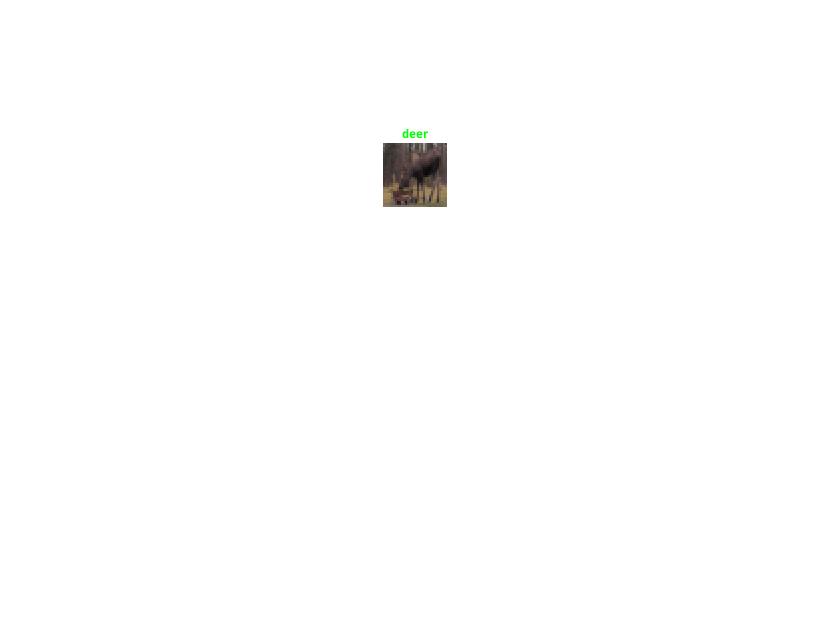

In [17]:
rootFolder = 'cifar10Test';
imds_test = imageDatastore(fullfile(rootFolder, categories), ...
    'LabelSource', 'foldernames');

labels = classify(net, imds_test);

ii = randi(4000);
im = imread(imds_test.Files{ii});
imshow(im);
if labels(ii) == imds_test.Labels(ii)
   colorText = 'g'; 
else
    colorText = 'r';
end
title(char(labels(ii)),'Color',colorText);

### Test one at a time
Run this section multiple times to get a feel for the random images and how they are being classified. If the title of the image is green, this is a correct prediction. If the title is red, the prediction is incorrect.

In [35]:
confMat = confusionmat(imds_test.Labels, labels);
confMat = confMat./sum(confMat,2);
mean(diag(confMat))


ans =

    0.7380

